In [1]:
%pylab inline

from scipy.stats.distributions import skewnorm
from scipy.optimize import leastsq

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc("font", size=20)
rc("text", usetex=True, **{"latex.preamble":r"\usepackage{amsmath},\usepackage{txfonts},\usepackage{eulervm},\usepackage{helvet}", "hinting":"native"})
rc("axes", linewidth=0.3)
rc("xtick.major", width=0.3)
rc("ytick.major", width=0.3)
rc("xtick.minor", width=0.3)
rc("ytick.minor", width=0.3)
rc("xtick", labelsize="x-small")
rc("ytick", labelsize="x-small")
rc("hatch", linewidth=0.5)
rc("grid", linewidth=0.3)
rc("savefig", format="pdf", dpi=50, bbox="tight")

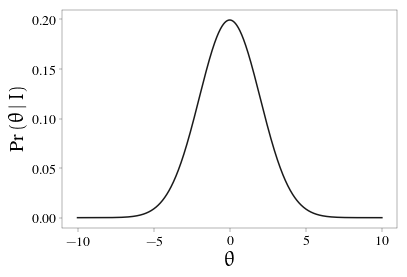

In [9]:
y = linspace(-10,10,1000)
sk, mu, sigma = 3, -0.55, 1.2
sk, mu, sigma = 0, 0, 2.0
plot(y,skewnorm.pdf(y, sk, mu, sigma), color="0.1")
#hist([skewnorm.rvs(1,0) for i in xrange(100)], normed=True)

xlabel(r"$\theta$")
ylabel(r"${\rm Pr}\left(\theta\,\middle|\,I\right)$")
#savefig("img/sample-pdf")

In [4]:
# modelo real
real_params = [1.5, 0.0]
real_model = lambda x, params: x**params[0]+params[1]
# modelo propuesto
model = lambda x, params: params[0]*x+params[1]

random.seed(0)

# Dominio de observaciones
X = linspace(1,10,100)

# muestreo del dominio de la variable independiente
N = 20
x = X[0]+random.rand(N)*(X[-1]-X[0])
# simulación de la observación
data = real_model(x, real_params) + array([skewnorm.rvs(sk,mu,sigma) for i in xrange(N)])

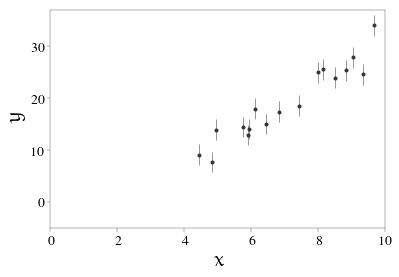

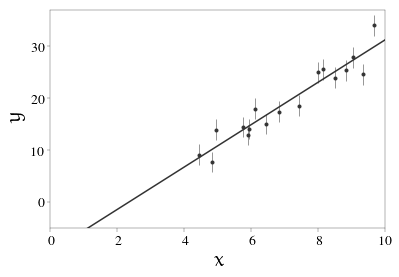

In [7]:
mask = x>4.0

# gráfico del conjunto de datos
figure()
errorbar(x[mask], data[mask], sigma, fmt=".", ecolor="0.2", color="0.2", lw=0.5)
xlim(0, 10)
ylim(-5, 37)
xlabel(r"$x$")
ylabel(r"$y$")

# gráfico del ajuste por mínimos cuadrados
figure()
# definir función a minimizar
residuals = lambda params: data[mask] - model(x[mask], params)
initial_params = [0.5, 0.0]
lsq_params = leastsq(residuals, initial_params)
old_params = lsq_params

plot(X, model(X, lsq_params[0]), "-", color="0.2", lw=1.5)
errorbar(x[mask], data[mask], sigma, fmt=".", ecolor="0.2", color="0.2", lw=0.5)
xlim(0, 10)
ylim(-5, 37)
xlabel(r"$x$")
ylabel(r"$y$")

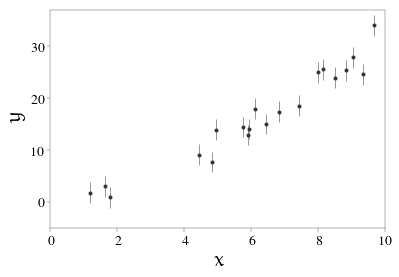

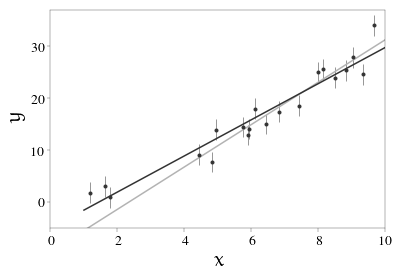

In [8]:
mask = x>0.0

# gráfico del conjunto de datos
figure()
errorbar(x[mask], data[mask], sigma, fmt=".", ecolor="0.2", color="0.2", lw=0.5)
xlim(0, 10)
ylim(-5, 37)
xlabel(r"$x$")
ylabel(r"$y$")

# gráfico del ajuste por mínimos cuadrados
figure()
# definir función a minimizar
residuals = lambda params: data[mask] - model(x[mask], params)
initial_params = [0.5, 0.0]
lsq_params = leastsq(residuals, initial_params)

plot(X, model(X, old_params[0]), "-", color="0.7", lw=1.5)
plot(X, model(X, lsq_params[0]), "-", color="0.2", lw=1.5)
errorbar(x[mask], data[mask], sigma, fmt=".", ecolor="0.2", color="0.2", lw=0.5)
xlim(0, 10)
ylim(-5, 37)
xlabel(r"$x$")
ylabel(r"$y$")